This script performs an unsupervised image classification of the results from our merge (and optionally clip) script.

The only new imports here would be scikit-learn, where we are using the KMeans clustering algorithm to classify pixels
by their spectral signature. 

In [1]:
from osgeo import gdal, osr
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Again, change the in_tif variable to the output path of the previous scripts. This can be either the 
clipped or the entire image.

In [2]:
in_tif = r"..\..\data\Austin_Landsat_Clip.tif"
in_ds = gdal.Open(in_tif)
arr_list = []

#Adds each band as an array
#I'm sure there's a more efficient way to get a GDAL raster as an n-dimensional array tho...
for i in range(1, in_ds.RasterCount +1):
    band = in_ds.GetRasterBand(i)
    arr = band.ReadAsArray()
    arr_list.append(arr)
in_data = np.dstack(np.array(arr_list)).T

This cell reshapes the n-dimensional array to 2-dimensions

In [3]:
samples = in_data.reshape((in_data.shape[0],-1)).T
y = np.ones(samples.shape)

This cell sets up the KMeans classifier with n_clusters, eg spectral signature classifications. 
This will take a little while to run...

In [4]:
kmeans = KMeans(n_clusters=5).fit_predict(samples)

This cell creates a new labels array from the output predictions and then
reshapes to the original dimensions of the dataset

In [5]:
labels= kmeans.reshape(in_data.shape[1], 
                       in_data.shape[2])

Let's take a look at the results, shall we?

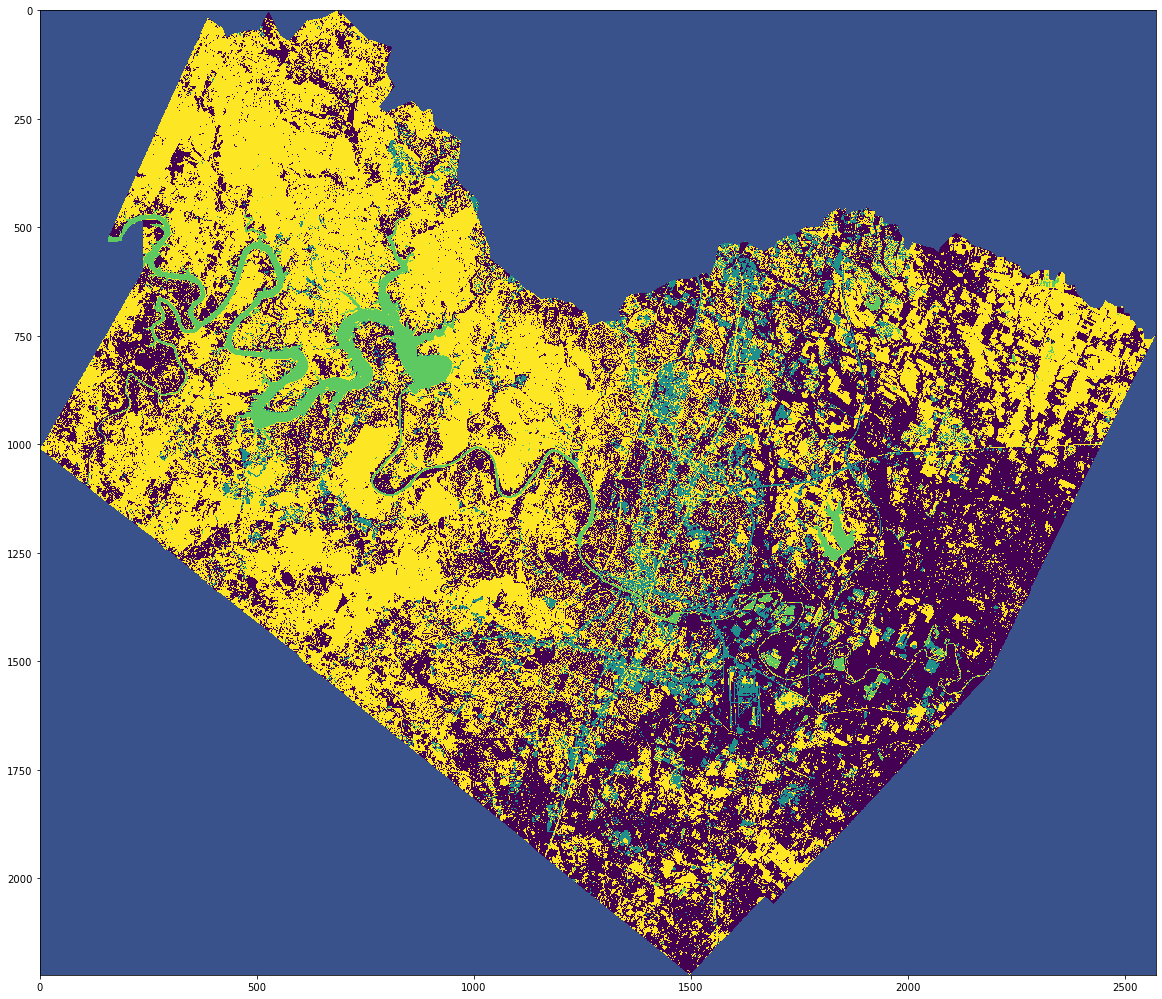

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(np.stack(labels).T)

Once again, change the 'out_tif' variable to whatever name you want to save this output raster to

In [7]:
out_tif = r"..\..\data\Austin_KMeans_Class.tif"
tif_driver = gdal.GetDriverByName("GTiff")
in_gt = in_ds.GetGeoTransform()
in_prj = in_ds.GetProjection()
in_srs = osr.SpatialReference(wkt=in_prj)

out_tif = tif_driver.Create(out_tif, 
                            arr_list[0].shape[1],
                            arr_list[0].shape[0],
                            1,
                            gdal.GDT_Float64)

out_tif.SetProjection(in_srs.ExportToWkt())
out_tif.SetGeoTransform(in_gt)
out_band = out_tif.GetRasterBand(1)
out_band.WriteArray(labels.T)
out_tif.FlushCache()